<a href="https://colab.research.google.com/github/dipen29/FE800_Project/blob/master/crude_oil_macro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fredapi

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [ ]:
# API keys
eia_api_key = 'imfRVLcrUNDvfhKnqO4KMgHenMPSlMUUFt0fWwfW'
fred_api_key = 'eebd1aff3e1198f4fedf3ccf3fb15830'

# URLs
base_url_spr = 'https://api.eia.gov/v2/petroleum/sum/sndw/data/'
base_url_crude_stock = 'https://api.eia.gov/v2/petroleum/sum/sndw/data/'
base_url_rig_drill = 'https://api.eia.gov/v2/petroleum/crd/drill/data/'
base_url_production = 'https://api.eia.gov/v2/petroleum/sum/snd/data/'

[*********************100%%**********************]  1 of 1 completed


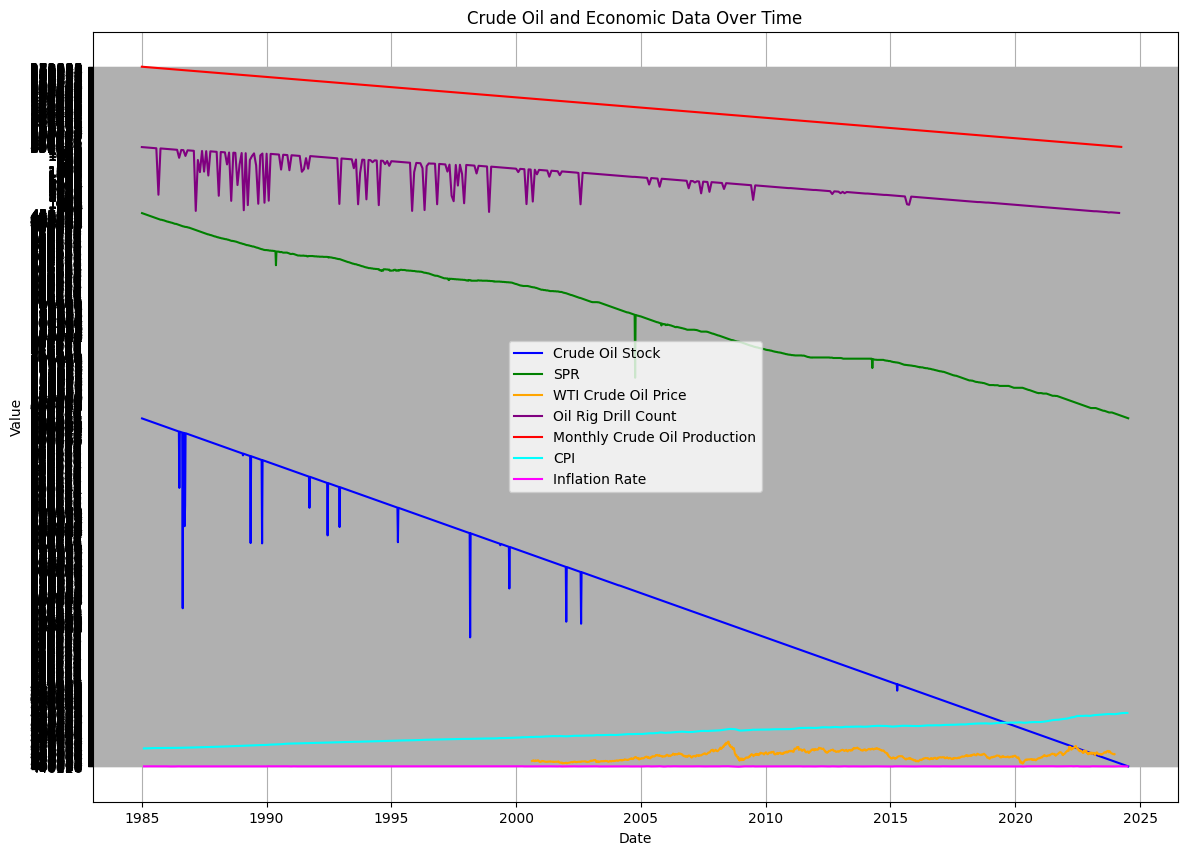

In [ ]:

def fetch_eia_data(series_id, base_url, api_key):
    params = {
        "frequency": "weekly",
        "data[0]": "value",
        "facets[series][0]": series_id,
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%d')
        df.set_index('period', inplace=True)
        return df[['value']]
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    spr_df = fetch_eia_data('WCSSTUS1', base_url_spr, eia_api_key)
    crude_oil_stock_df = fetch_eia_data('WCESTUS1', base_url_crude_stock, eia_api_key)
except ValueError as e:
    print(e)

def fetch_wti_crude_oil_price_yf(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    return df[['Close']]

start_date = '1982-08-08'
end_date = '2024-01-01'

try:
    wti_crude_oil_price_df = fetch_wti_crude_oil_price_yf('CL=F', start_date, end_date)
except Exception as e:
    print(f"Error fetching data: {e}")

def fetch_oil_rig_drill_data(api_key):
    params = {
        "frequency": "monthly",
        "data[0]": "value",
        "facets[series][]": "E_ERTRR0_XR0_NUS_C",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url_rig_drill, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        if 'period' in df.columns and 'value' in df.columns:
            df['period'] = pd.to_datetime(df['period'], format='%Y-%m', errors='coerce')
            df.set_index('period', inplace=True)
            df.dropna(inplace=True)
            return df[['value']]
        else:
            raise KeyError("Expected keys 'period' or 'value' not found in data")
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    oil_rig_drill_df = fetch_oil_rig_drill_data(eia_api_key)
except (ValueError, KeyError) as e:
    print(f"Data fetching or processing error: {e}")

def fetch_crude_oil_production_data(api_key):
    params = {
        "frequency": "monthly",
        "data[0]": "value",
        "facets[series][]": "MCRFPUS1",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url_production, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        if 'period' in df.columns and 'value' in df.columns:
            df['period'] = pd.to_datetime(df['period'], format='%Y-%m', errors='coerce')
            df.set_index('period', inplace=True)
            df.dropna(inplace=True)
            return df[['value']]
        else:
            raise KeyError("Expected keys 'period' or 'value' not found in data")
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    crude_oil_production_df = fetch_crude_oil_production_data(eia_api_key)
except (ValueError, KeyError) as e:
    print(f"Data fetching or processing error: {e}")

fred = Fred(api_key=fred_api_key)
cpi_data = fred.get_series('CPIAUCNS')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)
cpi_df = cpi_df.resample('M').mean()
cpi_df['Inflation'] = cpi_df['CPI'].pct_change() * 100

def filter_data(df, start_year):
    return df[df.index >= pd.to_datetime(f'{start_year}-01-01')]

start_year = 1985

if 'spr_df' in locals():
    spr_df = filter_data(spr_df, start_year)
if 'crude_oil_stock_df' in locals():
    crude_oil_stock_df = filter_data(crude_oil_stock_df, start_year)
if 'wti_crude_oil_price_df' in locals():
    wti_crude_oil_price_df = filter_data(wti_crude_oil_price_df, start_year)
if 'oil_rig_drill_df' in locals():
    oil_rig_drill_df = filter_data(oil_rig_drill_df, start_year)
if 'crude_oil_production_df' in locals():
    crude_oil_production_df = filter_data(crude_oil_production_df, start_year)
if 'cpi_df' in locals():
    cpi_df = filter_data(cpi_df, start_year)


plt.figure(figsize=(14, 10))

if 'spr_df' in locals() and 'crude_oil_stock_df' in locals():
    merged_df = pd.merge(crude_oil_stock_df, spr_df, left_index=True, right_index=True, suffixes=('_crude', '_spr'))
    plt.plot(merged_df.index, merged_df['value_crude'], label='Crude Oil Stock', color='blue')
    plt.plot(merged_df.index, merged_df['value_spr'], label='SPR', color='green')

if 'wti_crude_oil_price_df' in locals():
    plt.plot(wti_crude_oil_price_df.index, wti_crude_oil_price_df['Close'], label='WTI Crude Oil Price', color='orange')

if 'oil_rig_drill_df' in locals():
    plt.plot(oil_rig_drill_df.index, oil_rig_drill_df['value'], label='Oil Rig Drill Count', color='purple')


if 'crude_oil_production_df' in locals():
    plt.plot(crude_oil_production_df.index, crude_oil_production_df['value'], label='Monthly Crude Oil Production', color='red')

if 'cpi_df' in locals():
    plt.plot(cpi_df.index, cpi_df['CPI'], label='CPI', color='cyan')
    plt.plot(cpi_df.index, cpi_df['Inflation'], label='Inflation Rate', color='magenta')

plt.title('Crude Oil and Economic Data Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)


plt.show()

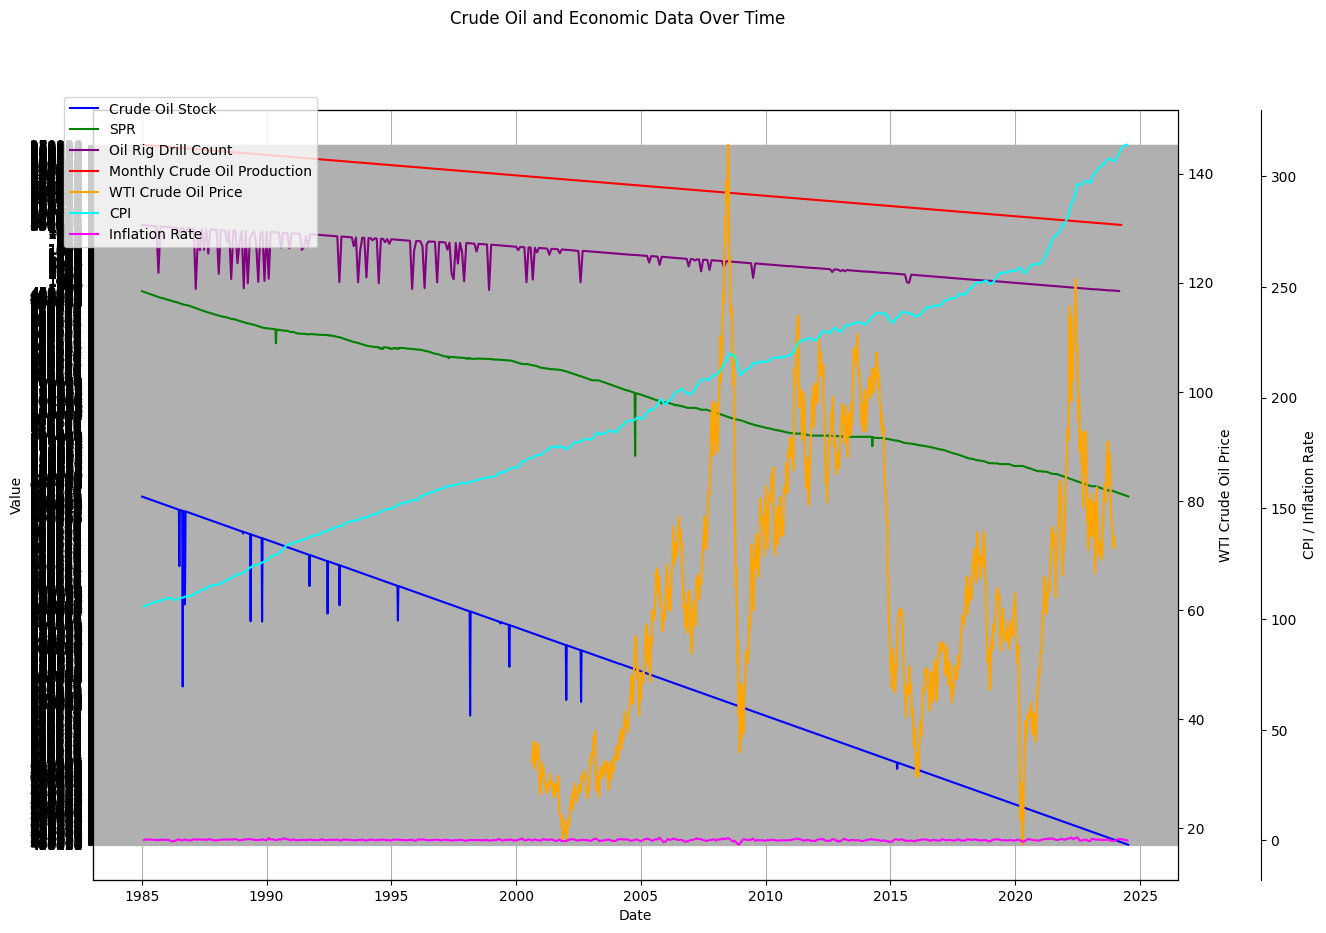

In [ ]:

# Create subplots with shared x-axis
fig, ax1 = plt.subplots(figsize=(14, 10))

color_map = {
    'Crude Oil Stock': 'blue',
    'SPR': 'green',
    'WTI Crude Oil Price': 'orange',
    'Oil Rig Drill Count': 'purple',
    'Monthly Crude Oil Production': 'red',
    'CPI': 'cyan',
    'Inflation Rate': 'magenta'
}

# Plotting each dataset on its own axis if needed
if 'spr_df' in locals() and 'crude_oil_stock_df' in locals():
    merged_df = pd.merge(crude_oil_stock_df, spr_df, left_index=True, right_index=True, suffixes=('_crude', '_spr'))
    ax1.plot(merged_df.index, merged_df['value_crude'], label='Crude Oil Stock', color=color_map['Crude Oil Stock'])
    ax1.plot(merged_df.index, merged_df['value_spr'], label='SPR', color=color_map['SPR'])

if 'wti_crude_oil_price_df' in locals():
    ax2 = ax1.twinx()
    ax2.plot(wti_crude_oil_price_df.index, wti_crude_oil_price_df['Close'], label='WTI Crude Oil Price', color=color_map['WTI Crude Oil Price'])

if 'oil_rig_drill_df' in locals():
    ax1.plot(oil_rig_drill_df.index, oil_rig_drill_df['value'], label='Oil Rig Drill Count', color=color_map['Oil Rig Drill Count'])

if 'crude_oil_production_df' in locals():
    ax1.plot(crude_oil_production_df.index, crude_oil_production_df['value'], label='Monthly Crude Oil Production', color=color_map['Monthly Crude Oil Production'])

if 'cpi_df' in locals():
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(cpi_df.index, cpi_df['CPI'], label='CPI', color=color_map['CPI'])
    ax3.plot(cpi_df.index, cpi_df['Inflation'], label='Inflation Rate', color=color_map['Inflation Rate'])

# Setting labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax2.set_ylabel('WTI Crude Oil Price')
ax3.set_ylabel('CPI / Inflation Rate')

fig.suptitle('Crude Oil and Economic Data Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adding grids
ax1.grid(True)

# Show plot
plt.show()


In [ ]:

def fetch_eia_data(series_id, base_url, api_key):
    params = {
        "frequency": "weekly",
        "data[0]": "value",
        "facets[series][0]": series_id,
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%d')
        df.set_index('period', inplace=True)
        return df[['value']]
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    spr_df = fetch_eia_data('WCSSTUS1', base_url_spr, eia_api_key)
    crude_oil_stock_df = fetch_eia_data('WCESTUS1', base_url_crude_stock, eia_api_key)
except ValueError as e:
    print(e)

def fetch_wti_crude_oil_price_yf(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    return df[['Close']]

start_date = '1982-08-08'
end_date = '2024-01-01'

try:
    wti_crude_oil_price_df = fetch_wti_crude_oil_price_yf('CL=F', start_date, end_date)
except Exception as e:
    print(f"Error fetching data: {e}")

def fetch_oil_rig_drill_data(api_key):
    params = {
        "frequency": "monthly",
        "data[0]": "value",
        "facets[series][]": "E_ERTRR0_XR0_NUS_C",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url_rig_drill, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        if 'period' in df.columns and 'value' in df.columns:
            df['period'] = pd.to_datetime(df['period'], format='%Y-%m', errors='coerce')
            df.set_index('period', inplace=True)
            df.dropna(inplace=True)
            return df[['value']]
        else:
            raise KeyError("Expected keys 'period' or 'value' not found in data")
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    oil_rig_drill_df = fetch_oil_rig_drill_data(eia_api_key)
except (ValueError, KeyError) as e:
    print(f"Data fetching or processing error: {e}")

def fetch_crude_oil_production_data(api_key):
    params = {
        "frequency": "monthly",
        "data[0]": "value",
        "facets[series][]": "MCRFPUS1",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    response = requests.get(base_url_production, params=params)
    data = response.json()
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        if 'period' in df.columns and 'value' in df.columns:
            df['period'] = pd.to_datetime(df['period'], format='%Y-%m', errors='coerce')
            df.set_index('period', inplace=True)
            df.dropna(inplace=True)
            return df[['value']]
        else:
            raise KeyError("Expected keys 'period' or 'value' not found in data")
    else:
        raise ValueError(f"Error fetching data: {data.get('error', 'Unknown error')}")

try:
    crude_oil_production_df = fetch_crude_oil_production_data(eia_api_key)
except (ValueError, KeyError) as e:
    print(f"Data fetching or processing error: {e}")

fred = Fred(api_key=fred_api_key)
cpi_data = fred.get_series('CPIAUCNS')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)
cpi_df = cpi_df.resample('M').mean()
cpi_df['Inflation'] = cpi_df['CPI'].pct_change() * 100

def filter_data(df, start_year):
    return df[df.index >= pd.to_datetime(f'{start_year}-01-01')]

start_year = 1985

if 'spr_df' in locals():
    spr_df = filter_data(spr_df, start_year)
if 'crude_oil_stock_df' in locals():
    crude_oil_stock_df = filter_data(crude_oil_stock_df, start_year)
if 'wti_crude_oil_price_df' in locals():
    wti_crude_oil_price_df = filter_data(wti_crude_oil_price_df, start_year)
if 'oil_rig_drill_df' in locals():
    oil_rig_drill_df = filter_data(oil_rig_drill_df, start_year)
if 'crude_oil_production_df' in locals():
    crude_oil_production_df = filter_data(crude_oil_production_df, start_year)
if 'cpi_df' in locals():
    cpi_df = filter_data(cpi_df, start_year)

merged_df = wti_crude_oil_price_df.resample('W').mean()

if 'spr_df' in locals():
    spr_resampled = spr_df.resample('W').mean()
    merged_df = merged_df.join(spr_resampled, rsuffix='_spr')
if 'crude_oil_stock_df' in locals():
    stock_resampled = crude_oil_stock_df.resample('W').mean()
    merged_df = merged_df.join(stock_resampled, rsuffix='_stock')
if 'oil_rig_drill_df' in locals():
    rig_resampled = oil_rig_drill_df.resample('W').mean()
    merged_df = merged_df.join(rig_resampled, rsuffix='_rig')
if 'crude_oil_production_df' in locals():
    production_resampled = crude_oil_production_df.resample('W').mean()
    merged_df = merged_df.join(production_resampled, rsuffix='_prod')
if 'cpi_df' in locals():
    cpi_resampled = cpi_df.resample('W').mean()
    merged_df = merged_df.join(cpi_resampled, rsuffix='_cpi')

def compute_lagged_correlations(df, target_col, max_lag):
    correlations = {}
    for lag in range(1, max_lag + 1):
        lagged_df = df.copy()
        lagged_df[target_col] = lagged_df[target_col].shift(lag)
        correlations[f'Lag_{lag}'] = lagged_df.corr()[target_col]
    return pd.DataFrame(correlations)

max_lag = 6  # 6 weeks
correlation_results = compute_lagged_correlations(merged_df, 'Close', max_lag)

print("Correlation with WTI Crude Oil Price with Lagged Values:")
print(correlation_results)


[*********************100%%**********************]  1 of 1 completed


Correlation with WTI Crude Oil Price with Lagged Values:
                Lag_1     Lag_2     Lag_3     Lag_4     Lag_5     Lag_6
Close        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
value        0.155506  0.151942  0.148015  0.143976  0.140169  0.136483
value_stock -0.015979 -0.018069 -0.019794 -0.021184 -0.022236 -0.023353
value_rig    0.559020  0.558942  0.563439  0.565450  0.580611  0.580750
value_prod   0.063650  0.072896  0.076290  0.079142  0.070589  0.076572
CPI          0.408603  0.412773  0.417709  0.418153  0.415403  0.408992
Inflation    0.210419  0.192648  0.178187  0.145909  0.100648  0.075570


In [ ]:

df_regression = merged_df[['Close', 'value', 'value_rig', 'CPI']]

df_regression = df_regression.apply(pd.to_numeric, errors='coerce')


df_regression = df_regression.dropna()

X = df_regression[['value', 'value_rig', 'CPI']]
y = df_regression['Close']

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print("Linear Regression Results using statsmodels:")
print(model.summary())

y_pred_sm = model.predict(X_sm)
mse_sm = mean_squared_error(y, y_pred_sm)
print("Mean Squared Error (statsmodels):", mse_sm)

linear_model = LinearRegression()
linear_model.fit(X, y)

print("Linear Regression Results using sklearn:")
print("Intercept:", linear_model.intercept_)
print("Coefficients:", linear_model.coef_)

y_pred_sklearn = linear_model.predict(X)
mse_sklearn = mean_squared_error(y, y_pred_sklearn)
print("Mean Squared Error (sklearn):", mse_sklearn)


Linear Regression Results using statsmodels:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     272.4
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.17e-76
Time:                        18:32:44   Log-Likelihood:                -950.23
No. Observations:                 242   AIC:                             1908.
Df Residuals:                     238   BIC:                             1922.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X, y)

# Predict and evaluate
y_pred = random_forest_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Random Forest Regressor Results:")
print("Mean Squared Error:", mse)

Random Forest Regressor Results:
Mean Squared Error: 9.72675474022591


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X, y)

y_pred = gradient_boosting_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Gradient Boosting Regressor Results:")
print("Mean Squared Error:", mse)


Gradient Boosting Regressor Results:
Mean Squared Error: 13.792424215623017


In [ ]:
from sklearn.svm import SVR


svr_model = SVR(kernel='rbf')
svr_model.fit(X, y)

y_pred = svr_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Support Vector Regressor Results:")
print("Mean Squared Error:", mse)


Support Vector Regressor Results:
Mean Squared Error: 660.7900481630027


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("XGBoost Regressor Results:")
print("Mean Squared Error:", mse)


XGBoost Regressor Results:
Mean Squared Error: 0.05969568443113771


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(X, y)

y_pred = mlp_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Neural Network Regressor Results:")
print("Mean Squared Error:", mse)

Neural Network Regressor Results:
Mean Squared Error: 20066013.84093669
